In [4]:
import pandas as pd
import numpy as np
import pingouin as pg
import requests
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st

In [5]:
def read_csv(url, sep=','):
    key = url
    api_url = "https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key="+key
    response = requests.get(api_url)
    download_url = response.json()['href']
    df = pd.read_csv(download_url, sep=sep)
    return df

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения.

1. В первую очередь, его интересует показатель **retention**. Надо написать функцию для его подсчета.
2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных необходимо определить, **какой набор можно считать лучшим и на основе каких метрик** стоит принять правильное решение.
3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

# Задание 1

Retention – один из самых важных показателей в компании. Необходимо написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). При этом функцию можно тестировать на части данных (каком-то определенном промежутке времени)

Данные о регистрациях: https://disk.yandex.ru/d/Xn78-_wgoIT6dA  
Данные об аутентификациях: https://disk.yandex.ru/d/BxnJZSKyNVQt_A

In [15]:
def retention(url_1, url_2, date_reg_1="1998-11-18", date_reg_2="2020-09-23"):

    """
    На вход функции подается период расчета метрики Retention, а также ссылка на данные с Яндекс диска
    """
    # Записываем данные о регистрации и аутентификации в переменные
    problem1_reg = read_csv(url_1, sep = ';')
    problem1_auth = read_csv(url_2, sep = ';')

    # Объединяем датасеты в один
    total_users = pd.merge(left = problem1_auth, right=problem1_reg, on ='uid', how='left')
    
    #Необходимо перевести время в формат datetime
    total_users.auth_ts = pd.to_datetime(total_users['auth_ts'], unit='s')
    total_users.reg_ts = pd.to_datetime(total_users['reg_ts'], unit='s')

    # Отбираем только ту часть данных, которая задана в функции
    #total_users_date = total_users.query('(reg_ts >= @date_reg_1 & reg_ts <= @date_reg_2) & \
     #                                     (auth_ts >= @date_reg_1 & auth_ts <= @date_reg_2)')

    filtration = (
        (total_users['reg_ts'] >= pd.to_datetime(date_reg_1)) &
        (total_users['reg_ts'] <= pd.to_datetime(date_reg_2)) &
        (total_users['auth_ts'] >= pd.to_datetime(date_reg_1)) &
        (total_users['auth_ts'] <= pd.to_datetime(date_reg_2))
    )

    total_users_date = total_users[filtration].copy()

    # Когортами будем считать время регистрации пользователей (так как это его первое целевое действие)
    # Оставляем только дату, вычитаем из времени аутентификации (последнего целевого действия) время регистрации (первого действия)
    total_users_date['day_reg'] = pd.to_datetime(total_users_date.reg_ts.dt.date)
    total_users_date['day_auth'] = pd.to_datetime(total_users_date.auth_ts.dt.date)
    total_users_date['timedelta'] = (total_users_date.day_auth - total_users_date.day_reg).dt.days

    # Делим пользователи на когорты, группируем по времени жизни когорты, считаем количество уникальных пользователей. 
    # Формируем сводную таблицу.
    cohort = total_users_date.groupby(['day_reg', 'timedelta'], as_index=False).uid.nunique()
    cohort_pivot = cohort.pivot(index = 'day_reg', columns = 'timedelta', values = 'uid')

    # Cчитаем размер самой длинной когорты, делим сводную таблицу на размер когорты и получаем Retention
    cohort_size = cohort_pivot[0]
    retention = cohort_pivot.divide(cohort_size, axis=0)

    # Строим график Retention
    plt.figure(figsize=(16,12))
    sns.heatmap(data = retention.iloc[:,1:],
                annot = True,
                fmt = '.1%',
                linewidth=.5,
                cmap = 'RdYlGn',
                yticklabels = retention.index.strftime('%Y-%m-%d'))

    plt.title(f"Retention за период {date_reg_1} - {date_reg_2}\n")
    plt.ylabel('Когорты\n')
    plt.xlabel('\nДни жизни')

    plt.show()

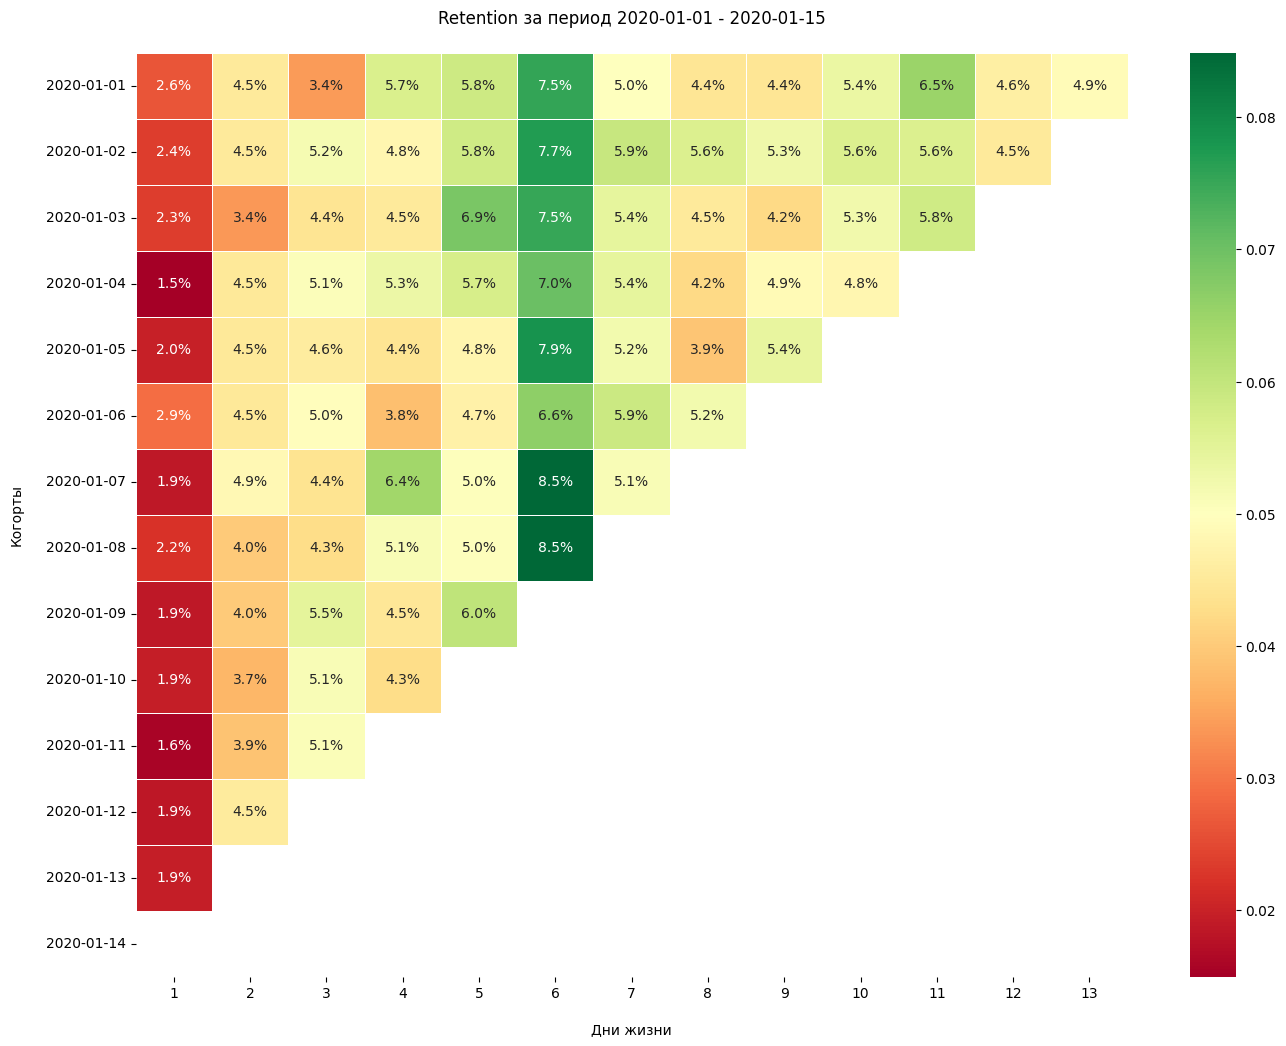

In [17]:
retention('https://disk.yandex.ru/d/Xn78-_wgoIT6dA', 'https://disk.yandex.ru/d/BxnJZSKyNVQt_A','2020-01-01', '2020-01-15')

# Задание 2

In [ ]:
data = read_csv('https://disk.yandex.ru/d/A8et0GwqDqmX0g', sep = ';')

In [ ]:
# Исследуем данные. Смотрим пустые значения, размер датасета, типы данных.
data.info()

In [ ]:
# Проверяю не оказался ли какой-либо пользователь в двух группах сразу
data.groupby('testgroup', as_index=False).user_id.count().user_id.sum()

In [ ]:
# Смотрим описательные статистики в двух группах
group_a = data.query('testgroup == "a"').describe()
group_b = data.query('testgroup == "b"').describe()
describe_groups = pd.concat([group_a, group_b], axis=1, keys = ['Group_A', 'Group_B'])

In [ ]:
describe_groups

Замечаем разницу в стандартных отклонениях и максимальных значениях двух выборок.

In [ ]:
std_dif = round(group_a.revenue['std'] / group_b.revenue['std'],2)

In [ ]:
print(f"Стандартное отклонениe в контрольной группе больше чем в тестовой в {std_dif} раза")

In [ ]:
max_dif = round(group_a.revenue['max'] / group_b.revenue['max'], 2)

In [ ]:
print(f"Максимальное значение выручки в контрольной группе больше чем в тестовой в {max_dif} раза")

In [ ]:
#Для наглядности построим графики распределения двух групп
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.histplot(data = data.query('testgroup == "a" & revenue != 0').revenue, bins = 50, color='orange')
plt.title('Контрольная группа\n')
plt.ylabel('Количество значений')
plt.xlabel('\nЗначения выручки')

plt.subplot(1,2,2)
sns.histplot(data = data.query('testgroup == "b" & revenue != 0').revenue, bins = 50, color = 'green')
plt.title('Тестовая группа\n')
plt.ylabel('Количество значений')
plt.xlabel('\nЗначения выручки')
plt.show()

#### Вывода по EDA

Проведен анализ двух выборок:  
1. Размер выборок отличается, но не значительно.
2. Стандартное отклонение в контрольной группе больше чем в тестовой в 3.2 раза.
3. Максимальное значение выручки в контрольной группе больше чем в тестовой в 9.36 раза.
4. Это означает большой разброс значений выручки в контрольной группе. Кроме того, в контрольной группе выборка сформирована неправильно. Большинство значений являются аномальными. Данная группа, как правило, не подходит для проведения дальнейшего тестирования. 

In [ ]:
# Добавляем колонку с платящими и неплатящими пользователями
data['pay_users'] = data.revenue.apply(lambda x: 1 if x > 0 else 0)

In [ ]:
# Группируем данные по тестовой и контрольной группам, считаем количество уникальных пользователей, платящих пользователей
# и общую выручку
data_metrics = data.groupby('testgroup', as_index=False).agg({'revenue':'sum', 'user_id':'nunique', 'pay_users':'sum'})

In [ ]:
# Высчитываем метрики ARPU, ARPPU и конверсию в оплату
data_metrics['ARPU'] = data_metrics.revenue / data_metrics.user_id
data_metrics['ARPPU'] = data_metrics.revenue / data_metrics.pay_users
data_metrics['CR_pay'] = data_metrics.pay_users / data_metrics.user_id *100

In [ ]:
data_metrics

In [ ]:
# Визуализируем метрики
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
ax = sns.barplot(x = 'testgroup', y = 'revenue', data = data)
plt.xlabel('Группа')
plt.ylabel('Выручка на одного пользователя')
plt.title('ARPU\n')

plt.subplot(1,3,2)
ax = sns.barplot(x = 'testgroup', y = 'revenue', data = data.query('revenue > 0'))
plt.xlabel('Группа')
plt.ylabel('Выручка на одного платящего пользователя')
plt.title('ARPPU\n')

plt.subplot(1,3,3)
ax = sns.barplot(x = 'testgroup', y = 'pay_users', data = data)
yticks = ax.get_yticks()
ax.set_yticklabels([f'{round(i*100,1)}%' for i in yticks])
plt.xlabel('Группа')
plt.ylabel('Значение конверсии')
plt.title('Конверсия в оплату\n')

plt.show()

После подсчета метрик выявлены различия между тестовой и контрольной группой.

### Метрика ARPU
Перед проведением теста формулируем гипотезы:  
**H0** - различий в ARPU между тестовой и контрольной группах нет.  
**H1** - различия в APRU меду тестовой и контрольной группах есть.

Уровень значимости (**p-value**): определим равным **0.05**

Проверим выборки на нормальность и равенство дисперсий

In [ ]:
# Проводим тест для определения нормальности.
pg.normality(data=data, group='testgroup', dv = 'revenue', method = 'normaltest')

In [ ]:
pg.qqplot(data.query('testgroup == "a"').revenue) 

In [ ]:
pg.qqplot(data.query('testgroup == "b"').revenue) 

In [ ]:
# Проверяем данные на равенство дисперсий
pg.homoscedasticity(data=data, group='testgroup', dv = 'revenue')

Для проверки гипотез будем использовать Т-тест Уэлча, так как дисперсии двух выборок равны, а сами выборки большие

In [ ]:
control = data.query('testgroup == "a"').revenue
test = data.query('testgroup == "b"').revenue

In [ ]:
#Проводим Т-тест Уэлча, так как размеры выборок разные
pg.ttest(control, test, correction = True)

Результаты теста показали, что нет **оснований опровергать нулевую гипотезу** о различиях между группами. 

## Метрика ARPPU

**H0** - различий в ARPPU между тестовой и контрольной группах нет.  
**H1** - различия в АRPPU между тестовой и контрольной группах есть.  
**p-value** = 0.05

Проверяем данные на нормальность и гомоскедостичность

In [ ]:
# Для проверки нормальности можно использовать метод Шапиро-Уилка, так как выборка меньше пяти тысяч.
pg.normality(data=data.query('revenue >0'), group='testgroup', dv = 'revenue', method = 'shapiro')

In [ ]:
# Проверяем равенство дисперсий
pg.homoscedasticity(data=data.query('revenue >0'), group='testgroup', dv = 'revenue', method = 'levene')

Для проверки гипотез также используем **Т-тест Уэлча**, так как выборки и их дисперсии не равны.

In [ ]:
control = data.query('revenue > 0 & testgroup == "a"').revenue
test = data.query('revenue > 0 & testgroup == "b"').revenue

In [ ]:
pg.ttest(control, test, correction=True)

Результаты теста показали p-value = 0.1, что **не позволяет отвергнуть нулевую гипотезу.**

### Метрика конверсия в оплату

Для метрики конверсии в оплату использую **критерий Хи-квадрат**, так как в частном случае его можно использовать для анализа конверсий. 

In [ ]:
chi_test = pd.crosstab(data.testgroup, data.pay_users)

In [ ]:
chi_test

In [ ]:
stat, p, dof, expected = st.chi2_contingency(chi_test)
print(f"Значение статистики: {stat}.")
print(f"Значение p-value: {p}.")
print(f"Степени свободы: {dof}.")
print(f"Ожидаемое наблюдение: {expected}.")

Исходя из значения статистической значимости (0.036) можно опровергнуть нулевую гипотезу о равенстве значения конверсии в оплату в двух группах.

Выводы:
1. Для оценки акционных предложений были выбраны метрики ARPU, ARPPU и конверсии в оплату, так как они отражают эффективность монетизации продукта и поведение пользователей на пути к продукту. Они позволяют выявить за счет чего растет прибыль. Таким образом, они помогут выявить эффективность акционных предложений
2. Выявлено, что значения метрик ARPU и ARPPU в группе Б выше, чем в группе А. Однако проведенные тесты не показали статистически значимых различий.
3. Значение метрики конверсии в оплату в группе А выше, чем в группе Б. Проверка гипотез показала статистически значимый результат, что конверсия в оплату в группе А выше, чем в группе Б.
4. Таким образом, наборы акционных предложений группы А можно считать лучшим, так как значение метрики конверсии в оплату в данной группе выше. Однако, различий между группами между другими ключевыми метриками (ARPU и ARPPU) не выявлено.